##### installing packages

In [8]:
!pip install transformers torch evaluate tqdm dataset

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

#### Loading packages

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import re
import pandas as pd
import string
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import torch, codecs, random
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from evaluate import load as load_metric
from google.colab import output
import matplotlib.pyplot as plt
from typing import List, Dict, Any
from transformers import PreTrainedTokenizer
from torch.optim import Optimizer
import nltk
nltk.download("wordnet")
nltk.download("stopwords")
from nltk.stem import PorterStemmer

output.enable_custom_widget_manager()

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/drive


## Data Preprocessing

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Tweets.csv")

df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [ ]:
df['sentiment'].value_counts()

,count
sentiment,
neutral,11118
positive,8582
negative,7781


In [5]:
df['text'] = df.text.astype(str)
df['sentiment'] = df['sentiment'].replace({'neutral': 0,
                                           'positive': 1,
                                           'negative': -1})

raw_tweets = df['text'].to_list()
labels = df['sentiment'].to_list()

In [6]:
# Removing whitespaces from the tweets

basic_preproc_tweets = [a.split() for a in raw_tweets]
print(basic_preproc_tweets[:3])

#Featurize - bag of words

tweet_dicts = [dict(Counter(tweet)) for tweet in basic_preproc_tweets]
vectorizer = DictVectorizer(sparse=False)
X = vectorizer.fit_transform(tweet_dicts)
vocabulary = vectorizer.get_feature_names_out()

print("Vocabulary:\n", vocabulary)
df_bow = pd.DataFrame(X, columns=vocabulary)
df_bow.head(5)

[['I`d', 'have', 'responded,', 'if', 'I', 'were', 'going'], ['Sooo', 'SAD', 'I', 'will', 'miss', 'you', 'here', 'in', 'San', 'Diego!!!'], ['my', 'boss', 'is', 'bullying', 'me...']]
Vocabulary:
 ['!' '!!' '!!!' ... 'ï¿½you' 'ï¿½ï¿½' 'ï¿½ï¿½h.']


,!,!!,!!!,!!!!,!!!!!,!!!!!!,!!!!!!!,!!!!!!!!,!!!!!!!!!,!!!!!!!!!!!!,...,ï¿½You,ï¿½anisalovesu,ï¿½n?eleg,ï¿½tearï¿½,ï¿½timo,ï¿½ureo,ï¿½why?,ï¿½you,ï¿½ï¿½,ï¿½ï¿½h.
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter
import pandas as pd

# regex patterns
HTML_URL_PATTERN = re.compile(r'<.*?>|http\S+')
NON_WORD_PATTERN = re.compile(r'\W+')  # Removes non-word characters

lemmatizer = WordNetLemmatizer()
STOP_WORDS = set(stopwords.words('english'))

def pre_process_without_oov(text):
    # Remove HTML/URLs
    text = HTML_URL_PATTERN.sub('', text)
    words = text.split()

    processed_words = []
    for word in words:
        word = word.lower()                       # Lowercase
        word = NON_WORD_PATTERN.sub('', word)     # Remove punctuation
        if not word:
            continue
        word = lemmatizer.lemmatize(word)         # Lemmatize
        if word in STOP_WORDS:                    # Remove stopwords
            continue
        word = 'NUM' if word.isdigit() else word  # Replace numbers
        processed_words.append(word)

    return processed_words

# Apply initial preprocessing
df['temp_processed'] = df['text'].apply(pre_process_without_oov)

# Determine top 1000 words
all_words = [word for sublist in df['temp_processed'] for word in sublist]
word_counts = Counter(all_words)
TOP_FREQ_WORDS = set(word for word, _ in word_counts.most_common(1000))

# Second pass to apply OOV replacement
def replace_oov(words):
    return ['OOV' if word not in TOP_FREQ_WORDS else word for word in words]

df['cleaned_text'] = df['temp_processed'].apply(replace_oov)
df.drop(columns=['temp_processed'], inplace=True)

In [ ]:
df.head()

,textID,text,selected_text,sentiment,cleaned_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",0,"[id, OOV, going]"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,-1,"[sooo, sad, miss, OOV, OOV]"
2,088c60f138,my boss is bullying me...,bullying me,-1,"[OOV, OOV]"
3,9642c003ef,what interview! leave me alone,leave me alone,-1,"[interview, leave, alone]"
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",-1,"[son, couldnt, put, OOV, already, bought]"


In [8]:
raw_tweets = df['cleaned_text'].to_list()

In [9]:
raw_tweets[:3]

[['id', 'OOV', 'going'], ['sooo', 'sad', 'miss', 'OOV', 'OOV'], ['OOV', 'OOV']]

In [ ]:
tweet_dicts = [dict(Counter(tweet)) for tweet in raw_tweets]
vectorizer_1 = DictVectorizer(sparse=False)
X_final = vectorizer_1.fit_transform(tweet_dicts)
vocabulary_final = vectorizer_1.get_feature_names_out()

print("Vocabulary:\n", vocabulary_final)

df_vocab = pd.DataFrame(X_final, columns=vocabulary_final)
df_vocab.head()

Vocabulary:
 ['1st' '2day' '2nd' ... 'yr' 'yum' 'yummy']


,1st,2day,2nd,3d,4th,NUM,OOV,_,able,absolutely,...,yet,yo,youll,young,youre,youtube,youve,yr,yum,yummy
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Splitting the data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_final,labels,test_size = 0.25, random_state=42)

print(X_train.shape)
print(X_test.shape)

(20610, 1001)
(6871, 1001)


# Machine Learning Model

## Baseline Model


Base Line Classifier Model - that contains frequent category. For that we create a list that contains most frequent class and compare it with *y_pred_baseline*

In [ ]:
frequency_count = Counter(y_train)
print(frequency_count)


most_frequent_class = frequency_count.most_common(1)[0][0]
print(most_frequent_class)

y_pred_baseline = [most_frequent_class] * len(y_test)

baseline_model_accuracy_score = accuracy_score(y_test, y_pred_baseline)
print(f"Baseline Classifier Accuracy: {baseline_model_accuracy_score:.4f}")

Counter({0: 8331, 1: 6455, -1: 5824})
0
Baseline Classifier Accuracy: 0.4056


## Naive Bayes

In [ ]:
naive_bayes_model = MultinomialNB(alpha=1.0)

# We use alpha parameter to add add-1 smoothing

naive_bayes_model.fit(X_train,y_train)

y_pred = naive_bayes_model.predict(X_test)

nb_accuracy = accuracy_score(y_test,y_pred)
print(f"Model Accuracy - Naive Bayes: {nb_accuracy:.4f}")

Model Accuracy - Naive Bayes: 0.6555


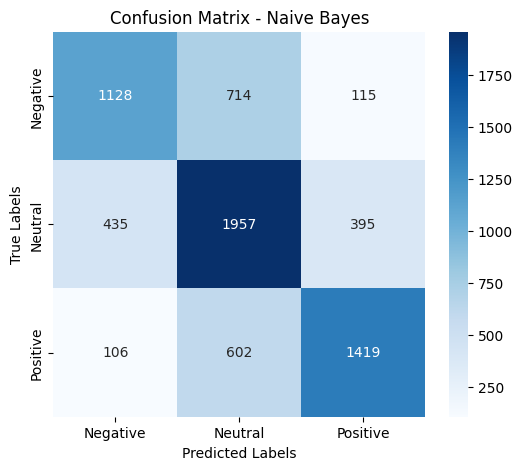

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

class_labels = ['Negative', 'Neutral', 'Positive']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()


## Logistic Regression

In [ ]:
lr_model = LogisticRegression(max_iter = 200,
                             multi_class = 'ovr')

lr_model.fit(X_train,y_train)
y_pred_lr = lr_model.predict(X_test)

lr_model_accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Model Accuracy - Logistic Regression: {lr_model_accuracy:.4f}")

Model Accuracy - Logistic Regression: 0.6861


In [ ]:
frequency_count = Counter(y_train)
most_frequent_class = frequency_count.most_common(1)[0][0]
y_pred_baseline = [most_frequent_class] * len(y_test)

baseline_model_accuracy_score = accuracy_score(y_test, y_pred_baseline)
print(f"Baseline Classifier Accuracy: {baseline_model_accuracy_score:.4f}")

print(f"The Logistic Regression model is better from baseline with an improvement of {lr_model_accuracy - baseline_model_accuracy_score:.4f}")

Baseline Classifier Accuracy: 0.4056
The Logistic Regression model is better from baseline with an improvement of 0.2805


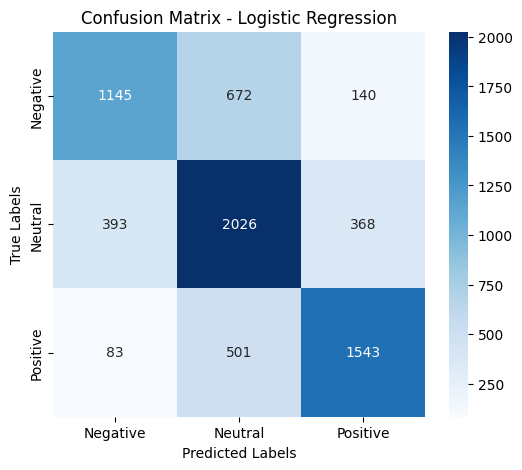

In [ ]:
cm_lr = confusion_matrix(y_test, y_pred_lr)

class_labels = ['Negative', 'Neutral', 'Positive']

plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

In [ ]:
if lr_model_accuracy > nb_accuracy:
    print(f"The LR model is better from NB with a difference of: {(lr_model_accuracy - nb_accuracy) * 100} %")
else:
    print(f"The NB model is better from LR with a difference of {(nb_accuracy - lr_model_accuracy)*100} %")

The LR model is better from NB with a difference of: 3.056323679231554 %


# DistilBERT and BERT Fine-tuning for Sentiment Classification

In [7]:
assert torch.cuda.is_available()

NameError: name 'torch' is not defined

In [5]:
dataset = df.copy()

#### Data Preparation

In [6]:
X = dataset['text'].to_list()
y = dataset['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2}).to_list()

In [11]:
# split X and y into a train/validation/test set, use fixed-indices (3000/1000/1000)
trainset, trainlabs = X[:20610], y[:20610]
valset, vallabs = X[20610:22610], y[20610:22610]
testset, testlabs = X[22610:], y[22610:]

print(f"Training examples: {len(trainset)}")
print(f"Validation examples: {len(valset)}")
print(f"Test examples: {len(testset)}")

Training examples: 20610
Validation examples: 2000
Test examples: 4871


Preparing the dataset as BERT requires [CLS] and [SEP] tokens.

In [12]:
class TweetDataset(torch.utils.data.Dataset):
  """
  A PyTorch Dataset for our tweets that can be iterated through using __getitem__
  """
  def __init__(self, tweets : List[str], sentiments : List[int], tokenizer : PreTrainedTokenizer) -> None:
    """
    Initializes the TweetDataset from a list of tweets, their corresponding sentiments, and a tokenizer.

    Attributes
    ----------
    tweets : List[str]
      A list of tweets, where each tweet is a string
    sentiments: List[int]
      A list of sentiments represented as integers ('negative': 0, 'neutral': 1, 'positive': 2)
    tokenizer : PreTrainedTokenizer
      Any PreTrainedTokenizer from HuggingFace can be used to encode the string inputs for a model
    """
    self.tweets = tweets
    self.sentiments = sentiments
    self.tokenizer = tokenizer
    self.max_len = tokenizer.model_max_length

  def __len__(self) -> int:
    """
    Returns the number of tweets in the dataset.
    """
    return len(self.tweets)

  def __getitem__(self, index : int) -> Dict[str, Any]:
    """
    Retrieve a preprocessed data item from the dataset at the specified index.
    This is called when iterating through a TweetDataset

    Parameters:
    ----------
    index : int
        The index of the data item to retrieve.

    Returns:
    -------
    Dict[str, Any]
        A dictionary containing the preprocessed data for the given index.
        The dictionary includes the following keys:
        - 'input_ids': Encoded input IDs for the tweet.
        - 'attention_mask': Attention mask for the tweet.
        - 'labels': Sentiment label as a PyTorch tensor.
    """
    tweet = str(self.tweets[index])
    sentiments = self.sentiments[index]

    encoded_tweet = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens      = True,
      max_length              = self.max_len,
      return_token_type_ids   = False,
      return_attention_mask   = True,
      return_tensors          = "pt",
      padding                 = "max_length",
      truncation              = True
    )

    return {
      'input_ids': encoded_tweet['input_ids'][0],
      'attention_mask': encoded_tweet['attention_mask'][0],
      'labels': torch.tensor(sentiments, dtype=torch.long)
    }

### Tokenizer and dataloader

In [13]:
from transformers import AutoTokenizer
from torch.utils.data import DataLoader

# tokenizer argument of the TweetDataset
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# TweetDataset objects
train_dataset = TweetDataset(trainset,trainlabs,tokenizer)
validation_dataset = TweetDataset(valset,vallabs,tokenizer)
test_dataset = TweetDataset(testset,testlabs,tokenizer)

# now construct DataLoader objects from the TweetDataset objects
# remember that the TweetDataset class is a child class of torch.utils.data.Dataset

train_dataloader = DataLoader(train_dataset,batch_size=32, shuffle = True)
validation_dataloader = DataLoader(validation_dataset,batch_size=32, shuffle = False)
test_dataloader = DataLoader(test_dataset,batch_size=32, shuffle = False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### Baseline Untrained Model

In [14]:
from transformers import AutoConfig, AutoModelForSequenceClassification

# getting the distilbert-base-uncased config...
config = AutoConfig.from_pretrained("distilbert-base-uncased", num_labels=3)

untrained_model = AutoModelForSequenceClassification.from_config(config)

In [15]:
# Evaluating model predictions on untrained model

# For any parameter named 'device', pass the following variable:
device = torch.device("cuda")

# Loading the model onto the device
untrained_model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [16]:
def update_metrics(metrics, predictions: torch.Tensor, labels: torch.Tensor) -> None:
  """
  Update a list of metrics with new predictions and labels

  Parameters:
  -----------
  metrics : List[Metric]
      List of metrics.
  predictions : torch.Tensor
      Tensor of predictions of shape (batch_size, ...)
  labels : torch.Tensor
      Tensor of labels of shape (batch_size, ...)

  Returns:
  --------
  None
  """
  for metric in metrics:
    metric.add_batch(predictions=predictions, references=labels)

# def evaluate(model: torch.nn.Module, test_dataloader: torch.utils.data.DataLoader,
#              device: torch.device, metric_strs: List[str]) -> Dict[str, float]:
#   """
#   Evaluate a PyTorch Model

#   Parameters:
#   -----------
#   model : torch.nn.Module
#       The model to be evaluated.
#   test_dataloader : torch.utils.data.DataLoader
#       DataLoader containing testing examples.
#   device : torch.device
#       The device that the evaluation will be performed on.
#   metric_strs : List[str]
#       The names of Hugging Face metrics to use.

#   Returns:
#   --------
#   Dict[str, float]
#       Dictionary of metric names mapped to their values.
#   """
#   # load metrics
#   metrics = [load_metric(x) for x in metric_strs] # could add more here!
#   model.eval()

#   # progress bars :)
#   progress_bar = tqdm(range(len(test_dataloader)))

#   with torch.no_grad():
#     for batch in test_dataloader:

#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         labels = batch['labels'].to(device)

#         outputs = model(input_ids = input_ids, attention_mask = attention_mask)
#         logits = outputs.logits

#         predictions = torch.argmax(logits, dim = -1).detach()

#         update_metrics(metrics, predictions, labels)

#         progress_bar.update(1)

#   computed = {}
#   for m in metrics:
#     computed = {**computed, **m.compute()}

#   return computed

from sklearn.metrics import classification_report

def evaluate(model: torch.nn.Module, test_dataloader: torch.utils.data.DataLoader,
             device: torch.device, metric_strs: List[str]) -> Dict[str, float]:
    """
    Evaluate a PyTorch Model and return metrics along with predictions.

    Parameters:
    -----------
    model : torch.nn.Module
        The model to be evaluated.
    test_dataloader : torch.utils.data.DataLoader
        DataLoader containing testing examples.
    device : torch.device
        The device that the evaluation will be performed on.
    metric_strs : List[str]
        The names of Hugging Face metrics to use.

    Returns:
    --------
    Dict[str, float]
        Dictionary of metric names mapped to their values.
    List[int]
        List of all predicted labels.
    List[int]
        List of all true labels.
    """
    # Load metrics
    metrics = [load_metric(x) for x in metric_strs]
    model.eval()

    # Store predictions and true labels
    all_preds, all_labels = [], []

    # Progress bar
    progress_bar = tqdm(range(len(test_dataloader)))

    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            predictions = torch.argmax(logits, dim=-1).detach().cpu().numpy()
            labels = labels.cpu().numpy()

            # Store for classification report
            all_preds.extend(predictions)
            all_labels.extend(labels)

            # Update metrics
            update_metrics(metrics, predictions, labels)

            progress_bar.update(1)

    computed = {}
    for m in metrics:
        computed = {**computed, **m.compute()}

    return computed, all_preds, all_labels

#### Baseline performance

In [17]:
from scipy.stats import describe
from math import sqrt

def make_plots(perfs: List[float], names: List[str]) -> None:
  """
  Create bar plots for performance metrics.

  Parameters:
  -----------
  perfs : List[float]
      List of performance values (e.g., accuracies).
  names : List[str]
      List of names for the corresponding performance metrics.
  """
  for perf, name in zip(perfs, names):
    print(f"{name} accuracy: {perf}")
  plt.bar(np.arange(len(perfs)), perfs)
  plt.xticks(np.arange(len(names)), names)
  plt.show()

  0%|          | 0/153 [00:00<?, ?it/s]

Baseline accuracy: 0.2861835352083761


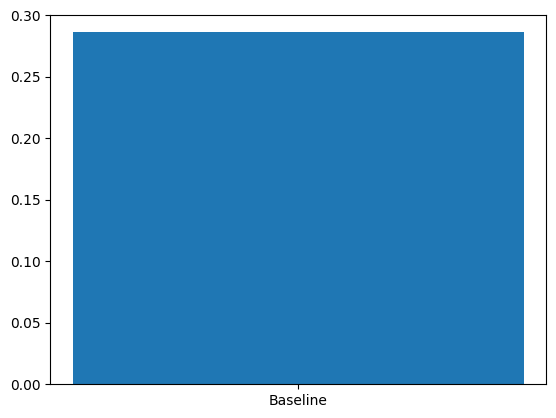

None


In [18]:
metrics = ['accuracy']

baseline_result = evaluate(model = untrained_model,
                           test_dataloader = test_dataloader,
                           device = device,
                           metric_strs = metrics)['accuracy']


#PLOT
results = [baseline_result]
names = ['Baseline']
print(make_plots(results, names))

### Baseline - Training the untrained model

In [19]:
def train(model: torch.nn.Module, optimizer: Optimizer, num_epochs: int,
          train_dataloader: DataLoader, validation_dataloader: DataLoader,
          lr_scheduler: Any, device: torch.device) -> None:
  """
  Trains a model by performing a forward pass and backpropating on batches to optimize loss.

  Parameters:
  -----------
  model : torch.nn.Module
      The model to be trained.
  optimizer : torch.optim.Optimizer
      The training optimizer.
  num_epochs : int
      Number of epochs to train for.
  train_dataloader : DataLoader
      DataLoader containing training examples.
  validation_dataloader : DataLoader
      DataLoader containing validation examples.
  lr_scheduler : Any
      Learning rate scheduler.
  device : torch.device
      The device that the training will be performed on.

  Returns:
  --------
  None
  """

  # CrossEntropyLoss - loss function
  loss_function = torch.nn.CrossEntropyLoss()

  for epoch in range(num_epochs):
    model.train()

    # load metrics
    metrics = [load_metric(x) for x in ["accuracy"]] # could add more here!

    print(f"Epoch {epoch + 1} training:")
    progress_bar = tqdm(range(len(train_dataloader)))

    for batch in train_dataloader:

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        loss = loss_function(logits, labels)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        lr_scheduler.step()

        predictions = torch.argmax(logits, dim=-1).detach()
        for metric in metrics:
            metric.add_batch(predictions=predictions, references=labels)

        progress_bar.update(1)

    # print the epoch's average metrics
    print(f"Epoch {epoch+1} average training metrics: accuracy={metrics[0].compute()['accuracy']}")

    # normally, validation would be more useful when training for many epochs
    print("Running validation:")

    val_metrics = evaluate(model, validation_dataloader, device, ["accuracy"])
    print(f"Epoch {epoch+1} validation: accuracy={val_metrics['accuracy']}")

In [20]:
# Training the model

from transformers import get_scheduler
from torch.optim import AdamW

num_epochs = 2

optimizer = AdamW(untrained_model.parameters(), lr=5e-5)

lr_scheduler = get_scheduler(
  "linear",
  optimizer=optimizer,
  num_warmup_steps=50,
  num_training_steps=len(train_dataloader) * num_epochs
)

torch.cuda.empty_cache()
untrained_model.to(device)

train(untrained_model,
      optimizer, num_epochs,
      train_dataloader,
      validation_dataloader,
      lr_scheduler,
      device)

Epoch 1 training:


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 1 average training metrics: accuracy=0.581756428918001
Running validation:


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1 validation: accuracy=0.7
Epoch 2 training:


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 2 average training metrics: accuracy=0.7475012130033964
Running validation:


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2 validation: accuracy=0.729


  0%|          | 0/153 [00:00<?, ?it/s]

Baseline accuracy: 0.2861835352083761
Manually Trained accuracy: 0.728187230548142


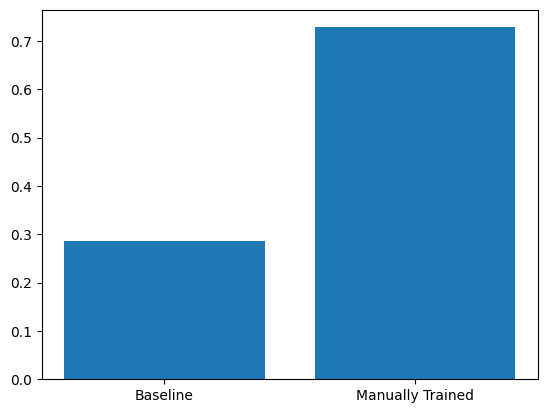

In [21]:
# Evaluate

metrics = ['accuracy']

# Evaluate on test dataset!
trained_result = evaluate(model=untrained_model,
    test_dataloader=test_dataloader,
    device=device,
    metric_strs=["accuracy"])['accuracy']

# Plot
results = baseline_result, trained_result
names = ['Baseline', 'Manually Trained']
make_plots(results, names)

### Fine-tuning pre-trained model

In [2]:
# Load pre-trained model

from transformers import DistilBertForSequenceClassification

pretrained_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased" , num_labels = 3
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
device = torch.device("cuda")

pretrained_model.to(device)

pretrained_result = evaluate(
    model=pretrained_model,
    test_dataloader=test_dataloader,
    device=device,
    metric_strs=["accuracy"]
)['accuracy']

#Plot
results = [baseline_result, trained_result, pretrained_result]
names = ['Baseline', 'Manually trained', 'Pre-trained']
make_plots(results, names)

NameError: name 'torch' is not defined

Rather than train the model from scratch, we'll now fine-tune the pre-trained model! That is, we will take the model that was trained to predict masked words,
and now train it on our sentiment analysis task.
We'll fine-tune by simply running the `train` function on our pre-trained model with the training data! Fine-tune it for **2 epochs**.

In [ ]:
num_epochs = 2

optimizer = AdamW(pretrained_model.parameters(), lr=5e-5)

lr_scheduler = get_scheduler(
  "linear",
  optimizer=optimizer,
  num_warmup_steps=50,
  num_training_steps=len(train_dataloader) * num_epochs
)

torch.cuda.empty_cache()
pretrained_model.to(device)

#Training
train(pretrained_model,
      optimizer,
      num_epochs,
      train_dataloader,
      validation_dataloader,
      lr_scheduler,
      device)

Epoch 1 training:


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 1 average training metrics: accuracy=0.532
Running validation:


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1 validation: accuracy=0.667
Epoch 2 training:


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 2 average training metrics: accuracy=0.6993333333333334
Running validation:


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2 validation: accuracy=0.671


  0%|          | 0/32 [00:00<?, ?it/s]

Baseline accuracy: 0.423
Manually trained accuracy: 0.565
Pre-trained accuracy: 0.353
Fine-tuned accuracy: 0.755


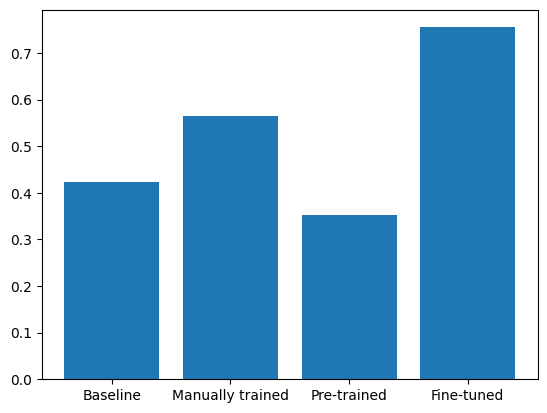

In [ ]:
# Evaluating the fine-tuned model

finetuned_result = evaluate(
    model = pretrained_model,
    test_dataloader = test_dataloader,
    device = device,
    metric_strs = ['accuracy']
)['accuracy']

#Plot
results = [baseline_result, trained_result, pretrained_result, finetuned_result]
names = ['Baseline', 'Manually trained', 'Pre-trained', 'Fine-tuned']
make_plots(results, names)

In [ ]:
# Evaluate DistilBERT
distilbert_results, distilbert_preds, distilbert_labels = evaluate(
    pretrained_model, test_dataloader, device, metric_strs=["accuracy"]
)

print("Classification Report for DistilBERT:")
print(classification_report(distilbert_labels, distilbert_preds, target_names=['Negative', 'Neutral', 'Positive']))

## BERT Model